In [0]:
import autograd.numpy as np
from autograd import grad

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import check_X_y
from sklearn.utils.validation import check_is_fitted, check_array, check_random_state, FLOAT_DTYPES


class DeadZoneRegression(BaseEstimator, RegressorMixin):
    def __init__(self, threshold=0.3, relative=False, effect="linear", n_iter=100, stepsize=0.0001):
        self.allowed_effects = ("constant", "linear", "quadratic")
        self.threshold = threshold
        self.relative = relative
        self.effect = effect
        self.n_iter = n_iter
        self.stepsize = stepsize

    def fit(self, X: np.array, y: np.array) -> "DeadZoneRegression":
        """
        Fit the model using X, y as training data.

        :param X: array-like, shape=(n_columns, n_samples,) training data.
        :param y: array-like, shape=(n_samples,) training data.
        :return: Returns an instance of self.
        """
        if self.effect not in self.allowed_effects:
            raise ValueError(f"effect {self.effect} is not in {self.allowed_effects}")
        X, y = check_X_y(X, y, estimator=self, dtype=FLOAT_DTYPES)

        def training_loss(weights):
            preds = np.dot(X, weights)
            error = y - preds
            if self.relative:
                error = (y - preds)/y
            abs_err = np.abs(error)
            if self.effect == "constant":
                final_err = np.where(abs_err > self.threshold, np.ones(abs_err.shape), np.zeros(abs_err.shape))
            if self.effect == "linear":
                final_err = np.where(abs_err > self.threshold, abs_err - self.threshold, np.zeros(abs_err.shape))
            if self.effect == "quadratic":
                final_err = np.where(abs_err > self.threshold, (abs_err - self.threshold)**2, np.zeros(abs_err.shape))
            return ((y - preds)**2).mean()
        
        self.loss_log = np.zeros(self.n_iter)
        self.wts_log = np.zeros((self.n_iter, X.shape[1]))
        self.deriv_log = np.zeros((self.n_iter, X.shape[1]))

        weights = np.random.normal(1, 2, (X.shape[1], 1))
        training_gradient = grad(training_loss)
        for i in range(self.n_iter):
            weights -= training_gradient(weights) * self.stepsize
            self.wts_log[i, :] = weights.ravel()
            self.loss_log[i] = training_loss(weights)
            self.deriv_log[i, :] = training_gradient(weights).ravel()
        self.coefs_ = weights
        return self

    def predict(self, X):
        """
        Predict new data by making random guesses.

        :param X: array-like, shape=(n_columns, n_samples,) training data.
        :return: array, shape=(n_samples,) the predicted data
        """
        check_is_fitted(self, ['coefs_'])

        X = check_array(X, estimator=self, dtype=FLOAT_DTYPES)
        return np.dot(X, self.coefs_)

In [8]:
import matplotlib.pylab as plt 

n, k = 100, 1
x_train = np.random.normal(0, 1, (n, k))
y_train = (np.random.normal(0, 0.5, (n, 1)) + 2 + x_train[:, 0].reshape(n, 1)).reshape(n)

mod = DeadZoneRegression(effect='linear', threshold=0.001, stepsize=0.1, n_iter=50)
x_train = np.concatenate([np.ones((n, 1)), x_train], axis=1)
mod.fit(x_train, y_train).coefs_

array([[ 2.02930452e+00],
       [-2.55986452e-05]])

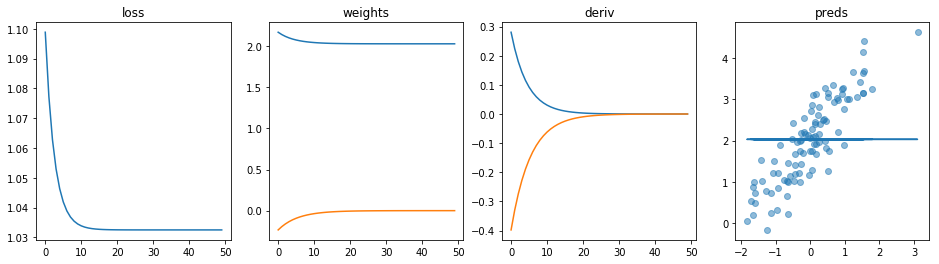

In [9]:
plt.figure(figsize=(16, 4))

plt.subplot(141)
plt.plot(mod.loss_log)
plt.title("loss")

plt.subplot(142)
plt.plot(mod.wts_log)
plt.title("weights");

plt.subplot(143)
plt.plot(mod.deriv_log)
plt.title("deriv");

plt.subplot(144)
plt.plot(x_train[:, 1], mod.predict(x_train))
plt.scatter(x_train[:, 1], y_train, alpha=0.5)
plt.title("preds");